# LDO 2025: Metodologia e memória de cálculo

## Header

In [220]:
from pandas import read_csv, concat, DataFrame, to_datetime, read_fwf
from bcb import Expectativas, sgs
from revenues_dict import revenues_dict
from overrides_dict import overrides_dict, full_overrides
from statsmodels.formula.api import ols
from numpy import log, exp, round, mean
from matplotlib.pyplot import scatter, plot, fill_between, show

from re import sub

## Dados

### Receitas

In [221]:
# Parameters
URL : str = 'https://dados.tce.rs.gov.br/dados/municipal/balancete-receita/%s/58500.csv'
PERIOD: range = range(2014,2025)

# Extract
revenues: DataFrame = concat([read_csv(URL %ano) for ano in PERIOD])

# Transform: filtering
revenues = revenues[revenues.CD_CONTA_SG.isin(revenues_dict.keys())]

# Transform: renaming
revenues.DS_CONTA_SG = revenues.CD_CONTA_SG.apply(lambda c : revenues_dict[c]['desc'])
revenues.CD_CONTA_SG = revenues.CD_CONTA_SG.apply(lambda c : revenues_dict[c]['cod'])

# # Transform: applying basic ratio forecasting
# revenues.loc[revenues.ANO  == 2024, 'VL_ARRECADADO'] = \
#     revenues.loc[revenues.ANO  == 2024, 'VL_ARRECADADO'].mul(12/8)

# Transform: pivoting
revenues = revenues.pivot_table(
    index='ANO',
    columns = 'DS_CONTA_SG',
    values = 'VL_ARRECADADO',
    aggfunc= 'sum'
)

revenues.impostos = revenues.impostos - revenues.limpeza_publica
revenues.transferencias = revenues.transferencias - revenues.fpm - revenues.icms

XTRAS_PATRIMONIAIS = 3426.71 + 20757.61
XTRAS_TOTAL = 4876732.06 + 2714252.08
XTRAS_TRANSFERENCIAS  = XTRAS_TOTAL - XTRAS_PATRIMONIAIS
revenues.at[2024, 'transferencias'] -= XTRAS_TRANSFERENCIAS
revenues.at[2024, 'patrimonial'] -= XTRAS_PATRIMONIAIS

revenues.loc[revenues.index == 2024] *= (12/8)

### Preços

In [222]:
# Extract: observed values
ipca_obs : DataFrame = sgs.get(('Media', 433), start='2014-01-01') \
                          .reset_index().rename(columns={'Date': 'DataReferencia'})


REF_DATE = '2024-10-11'

# Extract: expected values
ep_ipca_mon = Expectativas().get_endpoint('ExpectativaMercadoMensais')
ipca_exp_mon = ep_ipca_mon.query() \
                          .filter(
                             ep_ipca_mon.Indicador == 'IPCA',
                             ep_ipca_mon.Data == REF_DATE,
                             ep_ipca_mon.baseCalculo == '1'
                          ) \
                          .select(ep_ipca_mon.DataReferencia, ep_ipca_mon.Media) \
                          .collect()
ipca_exp_mon.DataReferencia = to_datetime(ipca_exp_mon.DataReferencia, format='%m/%Y')
ipca_exp_mon = ipca_exp_mon[ipca_exp_mon.DataReferencia > ipca_obs.DataReferencia.max()]

ep_ipca_year = Expectativas().get_endpoint('ExpectativasMercadoAnuais')
ipca_exp_year = ep_ipca_year.query() \
                             .filter(
                                ep_ipca_year.Indicador == 'IPCA',
                                ep_ipca_year.Data == REF_DATE,
                                ep_ipca_year.baseCalculo == '1'
                             ) \
                             .select(ep_ipca_year.DataReferencia, ep_ipca_year.Media) \
                             .collect()
ipca_exp_year.Media **= 1/12
ipca_exp_year.Media -= 1
ipca_exp_year.DataReferencia = to_datetime(ipca_exp_year.DataReferencia, format='%Y')
ipca_exp_year = ipca_exp_year.set_index('DataReferencia').resample('MS').first().ffill().reset_index()
ipca_exp_year = ipca_exp_year[ipca_exp_year.DataReferencia > ipca_exp_mon.DataReferencia.max()]


# # Transform: contatenating data
ipca = concat([ipca_obs, ipca_exp_mon, ipca_exp_year]).sort_values(by='DataReferencia')
ipca.columns = ['Date', 'ipca']

# Transform: index transformation
ipca.ipca = (ipca.ipca/100 + 1).cumprod()
ipca = ipca.reset_index(drop=True)

# Transform: resampling to yealy data
ipca = ipca.set_index('Date').resample('Y').last().reset_index()
ipca.ipca = ipca.ipca / ipca.ipca.min()
ipca.Date = ipca.Date.dt.year

/tmp/ipykernel_23438/1347071686.py:46: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  ipca = ipca.set_index('Date').resample('Y').last().reset_index()


### Juros

In [224]:
# Extract: observed values
selic_obs : DataFrame = sgs.get(('selic', 4390), start='2014-01-01', end='2023-12-31')

# Transform: yearly index transformation
for y in selic_obs.index.year.drop_duplicates():
    selic_obs.loc[selic_obs.index.year == y, 'selic'] = \
        (selic_obs.loc[selic_obs.index.year == y, 'selic'].div(100) + 1).cumprod()

selic_obs = selic_obs.resample('y').last()

# Extract: expected values, cfe. Focus 13/10/2023
selic_expec = DataFrame({
    'Date': [2024, 2025, 2026, 2027],
    'selic' : [1.1125, 1.105, 1.095, 1.09]
})

# Transform: index
selic_obs = selic_obs.reset_index()
selic_obs.Date = selic_obs.Date.dt.year

# Transform: concatening data
selic = concat([selic_obs, selic_expec])

/tmp/ipykernel_23438/1614887381.py:9: FutureWarning: 'y' is deprecated and will be removed in a future version, please use 'YE' instead.
  selic_obs = selic_obs.resample('y').last()


### IPM

In [225]:
# Extract
ipm = read_csv('../data/ipm.csv')

# Transform: renaming columns and formating data
ipm.columns = ['data', 'ipm']
ipm.data = ipm.data.str[:4].astype(int)

In [226]:
def project_ipm(breakpoints, base):
    df = ipm.set_index('data')
    variations = []
    for year in breakpoints:
        fist = df.at[year, 'ipm']
        last = df.at[year + 1, 'ipm']
        variation = (last - fist) / fist
        variations.append(variation)

    return df.at[base, 'ipm'] * (1 + mean(variations))

In [227]:
ipm = concat([
    ipm, 
    DataFrame({
        'data': 2027,
        'ipm': project_ipm([2020,2023], 2026)
        },
        index=[0]
    )
])

### Fit Dataset

In [228]:
# Transform: merging ipca
fit_set = revenues.reset_index() \
             .merge(ipca, left_on='ANO', right_on='Date') \
             .drop(columns='Date')

# Transform: merging ipm
fit_set = fit_set.merge(ipm, left_on='ANO', right_on='data') \
       .drop(columns='data')

# Transform: merging selic
fit_set = fit_set.reset_index() \
             .merge(selic, left_on='ANO', right_on='Date') \
             .drop(columns='Date')

In [229]:
# Dummys
fit_set['covid'] = fit_set.ANO.apply(lambda y : y == 2020).astype(int)
fit_set['concurso'] = fit_set.ANO.apply(lambda y : y in [2015, 2016, 2018, 2022]).astype(int)
fit_set['folha'] = fit_set.ANO.apply(lambda y : y in [2018, 2023]).astype(int)

# Transform: index
fit_set.set_index('ANO', inplace=True)

### Forecast Dataset

## Modelagem

### Método

In [230]:
class Model:
    
    def __init__(
        self, 
        spec, 
        model=ols, 
        is_log=False, 
        conf_level=.95, 
        data=fit_set, 
        index_col=None
    ):
        self._model = model
        self._spec = spec
        self._data = data
        self._is_log = is_log
        self._conf_level = conf_level
        self._index_col = self._data.index if index_col == None else self._data[index_col]

    def _fit(self):
        return self._model(self._spec, self._data).fit()
    
    def predict(self, exogs):
        result = self._fit().predict(exogs)
        return exp(result) if self._is_log else result

    def _results(self):
        fitted_model = self._fit()
        dependent_var_name = sub(r'log\(|\)' ,'',self._spec.split()[0])
        fitted_values = exp(fitted_model.fittedvalues) if self._is_log else fitted_model.fittedvalues
        conf_int_array = fitted_model.get_prediction().conf_int(self._conf_level)
        conf_int_values = exp(conf_int_array) if self._is_log else conf_int_array
        model_results = DataFrame(
            {
            'observed': self._data[dependent_var_name],
            'fitted' : fitted_values,
            'lower': [val[0] for val in conf_int_values],
            'higher': [val[1] for val in conf_int_values]
            },
        ).set_index(self._index_col)
        return model_results
    
    def get_summary(self):
        fitted_model = self._fit()
        model_summary = fitted_model.summary2()
        return model_summary
    
    def get_results(self):
        return self._results()

    def get_plot(self,file_name=None, title=None):
        data = self._results()
        scatter(data.index, data['observed'])
        plot(data.index, data['fitted'])
        fill_between(data.index, data['lower'], data['higher'], alpha=.2)
        # if file_name:
        #     if title:
        #         title(title)
        # 
        #     open(file_name, "w+").write(
        #         tikzplotlib.get_tikz_code(
        #             axis_width="15cm",
        #             axis_height="5cm"
        #         )
        #     )
        return show()

    def get_overview(self, exogs=fc_set):
        print(self.get_summary())
        self.get_plot()
        print(self.predict(exogs))

In [231]:
class Matrix:
    def __init__ (self, df, exception, model):
        self._df = df
        self._exception = exception
        self._model = model
    
    def _get_matrix(self):
        matrix = self._df[~self._df.cod.isin(self._exception)]
        total = matrix.value.sum()
        matrix['ratio'] = matrix['value'] / total
        return matrix
    
    def predict(self, exogs):
        top_level_fc = self._model.predict(exogs).sum()
        matrix = self._get_matrix()
        matrix['forecast'] = (matrix.ratio * top_level_fc).apply(lambda v : round(v / 1000) * 1000)
        return matrix

### Fit

In [251]:
# Forecasting set
PREDICT_YEAR = 2027


# Forecasting set: X vars
fc_set = selic.merge(ipca[ipca.Date == 2026]) \
              .merge(ipm, left_on='Date', right_on='data') \
              .merge(selic)

# Forecasting set: Dummys
fc_set[['covid', 'concurso', 'folha']] = 0

In [252]:
# Modeling
impostos_model = Model('log(impostos) ~ log(ipca)', is_log=True, data=fit_set[(fit_set.index >= 2017)])# & (fit_set.index <= 2022)])
contribuicoes_model = Model('log(contribuicoes) ~ log(ipca)', is_log=True) # ver melhor
patrimonial_model = Model('patrimonial ~ selic + ipca')
servicos_model = Model('servicos ~ concurso + folha ')
transferencias_model = Model('transferencias ~ log(ipca) + covid')
outras_model = Model('log(outras) ~ log(ipca)', is_log=True, data=fit_set[fit_set.index >= 2019])

# faltam: limpeza pública, fpm e icms

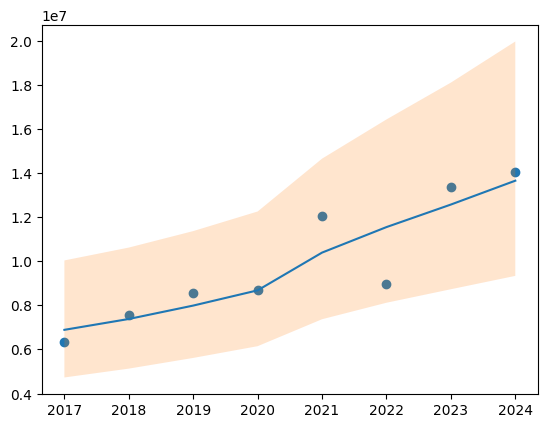

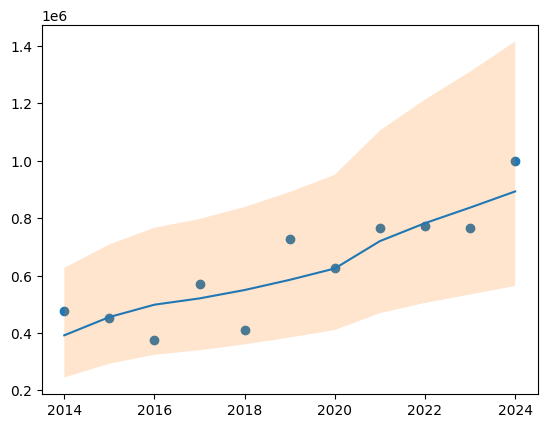

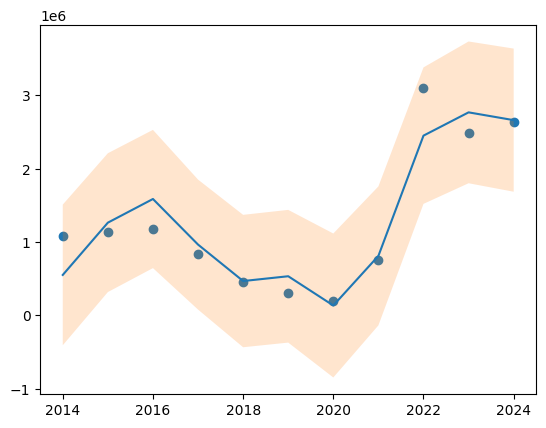

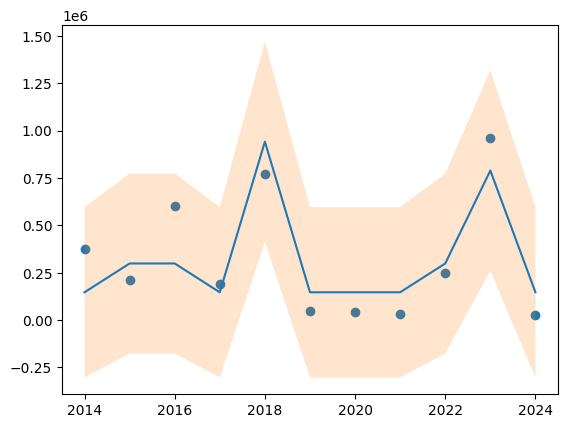

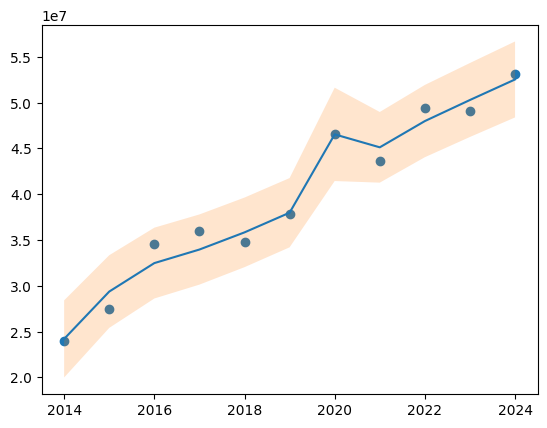

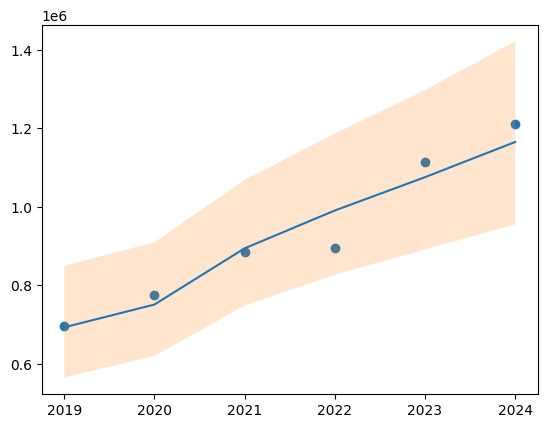

[None, None, None, None, None, None]

In [253]:
models = [impostos_model, contribuicoes_model, patrimonial_model, servicos_model, transferencias_model, outras_model]

[model.get_plot() for model in models]

### Matriz

In [254]:
# # Extract
fc_base = read_csv(URL %2024)

# Transform: slicing
fc_base = fc_base.loc[fc_base.NIVEL == 'A', 
                      ['CD_CONTA_SG', 'DS_CONTA_SG', 'NIVEL', 'VL_ORCADO']]

# Transform: renaming
fc_base.columns = ['cod', 'desc', 'level', 'value']

# Load: Creating top level group
impostos_base = fc_base[fc_base.cod.str.startswith('11')]
limpeza_base = fc_base[fc_base.cod.str.contains(r'^112253')]
contribuicoes_base = fc_base[fc_base.cod.str.startswith('12')]
patrimonial_base = fc_base[fc_base.cod.str.startswith('13')]
servicos_base = fc_base[fc_base.cod.str.startswith('16')]
transferencias_base = fc_base[fc_base.cod.str.startswith('17')
                              & ~fc_base.cod.str.startswith('171151')
                              & ~fc_base.cod.str.startswith('17215001')]
fpm_base = fc_base[fc_base.cod.str.startswith('171151')]
icms_base = fc_base[fc_base.cod.str.startswith('17215001')]
outras_base = fc_base[fc_base.cod.str.startswith('19')]

In [255]:
impostos_fc = Matrix(impostos_base, 
                     ['11225300000000000000'], 
                     impostos_model).predict(fc_set)

contribuicoes_fc = Matrix(contribuicoes_base, 
                          [], contribuicoes_model).predict(fc_set)

patrimonial_fc = Matrix(patrimonial_base, [], patrimonial_model).predict(fc_set)

servicos_fc = Matrix(servicos_base, [], servicos_model).predict(fc_set)

transferencias_fc = Matrix(transferencias_base, [], transferencias_model).predict(fc_set) # deduzir 1.1 no hospital

outras_fc = Matrix(outras_base, [], outras_model).predict(fc_set)

## Results

In [256]:
ipca_diff = ipca.copy()
ipca_diff.ipca /= ipca_diff.loc[ipca_diff.Date == 2025, 'ipca'].values[0]
ipca_diff.set_index('Date', inplace=True)

## Overrides

In [257]:
limpeza_bc =  1720000.
# ipca_diff = (ipca.set_index('Date').diff(periods=1) + 1)
# ipca_diff = ipca_diff[ipca_diff.index == 2026].ipca.item()
# limpeza_predict = ipca_diff.at[PREDICT_YEAR, 'ipca'] * limpeza_bc

limpeza_predict = limpeza_bc
limpeza_fc = limpeza_base
limpeza_fc['ratio'] = limpeza_fc.value / limpeza_fc.value.sum()
limpeza_fc['forecast'] = round(limpeza_fc.ratio * limpeza_predict / 1000) * 1000

/tmp/ipykernel_23438/2680896490.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  limpeza_fc['ratio'] = limpeza_fc.value / limpeza_fc.value.sum()
/tmp/ipykernel_23438/2680896490.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  limpeza_fc['forecast'] = round(limpeza_fc.ratio * limpeza_predict / 1000) * 1000


In [258]:
# fpm: https://sisweb.tesouro.gov.br/apex/f?p=2501:9::::9:P9_ID_PUBLICACAO:50503

fpm_predict =  34948000 / .8
fpm_fc = fpm_base

fpm_fc['ratio'] =  fpm_base.value / fpm_base.value.sum()
fpm_fc['forecast'] = round(fpm_fc.ratio * fpm_predict / 1000) * 1000

/tmp/ipykernel_23438/3457813839.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fpm_fc['ratio'] =  fpm_base.value / fpm_base.value.sum()
/tmp/ipykernel_23438/3457813839.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fpm_fc['forecast'] = round(fpm_fc.ratio * fpm_predict / 1000) * 1000


In [259]:
reducao_assistir = 1100000

transferencias_fc.loc[
    transferencias_fc.cod.str.startswith('1723500107'),
    'forecast'] = \
    transferencias_fc.loc[
        transferencias_fc.cod.str.startswith('1723500107'),
        'forecast'] - reducao_assistir

In [260]:
# https://planejamento.rs.gov.br/upload/arquivos/202409/12160451-volume-ii-2025.pdf
# 13.374.624.186
# 0.194449

reducao_saers = 800000

# icms_predict = (13374624186 * .194449 / 100) - reducao_saers
icms_predict = (13374624186 * ipm.set_index('data').at[PREDICT_YEAR, 'ipm'] / 100) - reducao_saers
icms_fc = icms_base

icms_fc['ratio'] = icms_fc.value / icms_fc.value.sum()
icms_fc['forecast'] = round(icms_fc.ratio * icms_predict /1000)*1000

/tmp/ipykernel_23438/3311601342.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  icms_fc['ratio'] = icms_fc.value / icms_fc.value.sum()
/tmp/ipykernel_23438/3311601342.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  icms_fc['forecast'] = round(icms_fc.ratio * icms_predict /1000)*1000


In [261]:
fpm_fc.forecast *= ipca_diff.at[2026, 'ipca']
limpeza_fc.forecast *= ipca_diff.at[2026, 'ipca'] 
#transferencias_fc.forecast *= ipca_diff.at[2026, 'ipca']
icms_fc.forecast *= ipca_diff.at[2026, 'ipca']

/tmp/ipykernel_23438/1806683681.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fpm_fc.forecast *= ipca_diff.at[2026, 'ipca']
/tmp/ipykernel_23438/1806683681.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  limpeza_fc.forecast *= ipca_diff.at[2026, 'ipca']
/tmp/ipykernel_23438/1806683681.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

## Resultados consolidados

In [262]:
loa = concat([contribuicoes_fc, fpm_fc, icms_fc, impostos_fc, 
              limpeza_fc, outras_fc, patrimonial_fc, servicos_fc,
              transferencias_fc])

In [263]:
loa_code_count : DataFrame = loa.cod.value_counts().reset_index()
loa_code_count.columns = ['cod', 'qtd']
repeated_codes = loa_code_count[loa_code_count.qtd > 1].cod
loa = loa[~(loa.cod.isin(repeated_codes) & (loa.forecast == 0))]

In [264]:
for cod in overrides_dict.keys():
    revenue = loa.loc[loa.cod.str.startswith(cod), 'forecast']
    if len(revenue):
        loa.loc[loa.cod.str.startswith(cod), 'forecast'] = \
            loa.loc[loa.cod.str.startswith(cod), 'forecast'] \
            + overrides_dict[cod]
    else:
        pass

In [265]:
for cod in full_overrides.keys():
    revenue = loa.loc[loa.cod.str.startswith(cod), 'forecast']
    if len(revenue):
        loa.loc[loa.cod.str.startswith(cod), 'forecast'] = \
            round(full_overrides[cod] / 1000) * 1000
    else:
        pass

### SKs

In [266]:
sk_base : DataFrame = read_fwf('../data/relacao-receita-2024.TXT', skiprows=1)
sk_base[['sk', 'cod']] = sk_base.Receita.str.split(r'\s{1,}', n=1, expand=True)
sk_base = sk_base[sk_base.sk.str.isnumeric()]
sk_base.cod = sk_base.cod.str.replace('.','') + '000000'

sk = sk_base[['sk', 'cod']]
#sk = sk[sk.sk.str.isnumeric()]

full_loa = sk.merge(loa, how='right')

full_loa.loc[full_loa.forecast == 0, 'forecast'] = 1000

# Hotfix duplicação da receita do hospial
full_loa = full_loa[~((full_loa.cod == '17235001070000000000') & (full_loa.value == 0))]

In [267]:
def check(df, rows=None):
    check_df = df.sort_values(by='forecast', ascending=False)
    check_df['%'] = check_df.forecast / check_df.forecast.sum()
    check_df['cum %'] = check_df['%'].cumsum()

    return check_df.head(rows) if rows else check_df
    

In [268]:
full_loa[['value', 'forecast']].sum()

value       1.423907e+08
forecast    1.671265e+08
dtype: float64

In [269]:
# full_loa[['sk', 'cod', 'desc', 'forecast']].to_csv(f'ldo{PREDICT_YEAR}v1.csv', index=False)
# full_loa[['sk', 'cod', 'desc', 'forecast']].to_excel(f'ldo{PREDICT_YEAR}v1.xlsx', index=False)